In [1]:
import torch
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
import util
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from time import time
import argparse
from datetime import date
from progressbar import *

In [2]:
import os
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
                         # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import seaborn as sns
np.random.seed(2)

In [3]:
class Backbone(nn.Module):

    def __init__(self, global_hidden_size, n_global_factors, num_layers):
        super(Backbone, self).__init__()
        self.transformer = TransAm(global_hidden_size)
        self.factor = nn.Linear(global_hidden_size, n_global_factors)

    def forward(self, X):
        num_ts, num_features = X.shape
        X = X.unsqueeze(1)
        ht = self.transformer(X)
        ht = F.relu(ht)
        gt = ht
        return gt.view(num_ts, -1)

In [4]:
class Noise(nn.Module):

    def __init__(self, noise_hidden_size, num_layers):
        super(Noise, self).__init__()
        self.transformer = TransAm(noise_hidden_size, num_layers)
        self.affine = nn.Linear(noise_hidden_size, 1)

    def forward(self, X):
        num_ts, num_features = X.shape
        X = X.unsqueeze(1)
        ht = self.transformer(X)
        ht = F.relu(ht)
        sigma_t = self.affine(ht)
        sigma_t = torch.log(1 + torch.exp(sigma_t))
        return sigma_t.view(-1, 1)

In [5]:
class TDPnet(nn.Module):

    def __init__(self, noise_hidden_size, global_hidden_size, n_global_factors, num_layers):
        super(TDPnet, self).__init__()
        self.noise = Noise(noise_hidden_size, num_layers)
        self.global_factor = Backbone(global_hidden_size, n_global_factors, num_layers)
        self.embed = nn.Linear(global_hidden_size, n_global_factors)
    
    def forward(self, X,):
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
        num_ts, num_periods, num_features = X.size()
        mu = []
        sigma = []
        for t in range(num_periods):
            gt = self.global_factor(X[:, t, :])
            ft = self.embed(gt)
            ft = ft.sum(dim=1).view(-1, 1)
            sigma_t = self.noise(X[:, t, :])
            mu.append(ft)
            sigma.append(sigma_t)
        mu = torch.cat(mu, dim=1).view(num_ts, num_periods)
        sigma = torch.cat(sigma, dim=1).view(num_ts, num_periods) + 1e-6
        return mu, sigma
    
    def sample(self, X, num_samples=100):
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
        mu, var = self.forward(X)
        num_ts, num_periods = mu.size()
        z = torch.zeros(num_ts, num_periods)
        for _ in range(num_samples):
            dist = torch.distributions.normal.Normal(loc=mu, scale=var)
            zs = dist.sample().view(num_ts, num_periods)
            z += zs
        z = z / num_samples
        return z

In [6]:
def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int):
    seq_len (int): sequence/encoder/decoder length
    batch_size (int)
    '''
    num_ts, num_periods, _ = X.shape
    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    batch = random.sample(range(num_ts), batch_size)
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len]
    yf = y[batch, t:t+seq_len]
    return X_train_batch, y_train_batch, Xf, yf

In [7]:
def train(
    X, 
    y,
    args
    ):
    '''
    Args:
    - X (array like): shape (num_samples, num_features, num_periods)
    - y (array like): shape (num_samples, num_periods)
    - epoches (int): number of epoches to run
    - step_per_epoch (int): steps per epoch to run
    - seq_len (int): output horizon
    - likelihood (str): what type of likelihood to use, default is gaussian
    - num_skus_to_show (int): how many skus to show in test phase
    - num_results_to_sample (int): how many samples in test phase as prediction
    '''
    # rho = args.quantile
    num_ts, num_periods, num_features = X.shape
    model = TDPnet(
        args["noise_hidden_size"],args["global_hidden_size"], args["n_factors"], args["Transformerheads"])
    optimizer = Adam(model.parameters(), lr=args["lr"])

    random.seed(2)
    # select sku with most top n quantities 
    Xtr, ytr, Xte, yte = util.train_test_split(X, y)
    losses = []
    cnt = 0

    yscaler = None
    if args["standard_scaler"]:
        yscaler = util.StandardScaler()
    elif args["log_scaler"]:
        yscaler = util.LogScaler()
    elif args["mean_scaler"]:
        yscaler = util.MeanScaler()
    if yscaler is not None:
        ytr = yscaler.fit_transform(ytr)

    # training
    progress = ProgressBar()
    seq_len = args["seq_len"]
    num_obs_to_train = args["num_obs_to_train"]
    for epoch in progress(range(args["num_epoches"])):
        for step in range(args["step_per_epoch"]):
            Xtrain, ytrain, Xf, yf = batch_generator(Xtr, ytr, num_obs_to_train, 
                        seq_len, args["batch_size"])
            Xtrain_tensor = torch.from_numpy(Xtrain).float()
            ytrain_tensor = torch.from_numpy(ytrain).float()
            Xf = torch.from_numpy(Xf).float()  
            yf = torch.from_numpy(yf).float()
            mu, sigma = model(Xtrain_tensor)
            loss = util.gaussian_likelihood_loss(ytrain_tensor, mu, sigma)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cnt += 1
            
    
    # test 
    mape_list = []
    # select skus with most top K
    X_test = Xte[:, -seq_len-num_obs_to_train:-seq_len, :].reshape((num_ts, -1, num_features))
    Xf_test = Xte[:, -seq_len:, :].reshape((num_ts, -1, num_features))
    y_test = yte[:, -seq_len-num_obs_to_train:-seq_len].reshape((num_ts, -1))
    yf_test = yte[:, -seq_len:].reshape((num_ts, -1))
    if yscaler is not None:
        y_test = yscaler.transform(y_test)
    
    result = []
    n_samples = args["sample_size"]
    for _ in tqdm(range(n_samples)):
        y_pred = model.sample(Xf_test)
        y_pred = y_pred.data.numpy()
        if yscaler is not None:
            y_pred = yscaler.inverse_transform(y_pred)
        result.append(y_pred.reshape((-1, 1)))
    
    
    result = np.concatenate(result, axis=1)
    p50 = np.quantile(result, 0.5, axis=1)
    p90 = np.quantile(result, 0.9, axis=1)
    p10 = np.quantile(result, 0.1, axis=1)
    print("p50 {}".format(p50))

    mape = util.MAPE(yf_test, p50)
    print("P50 MAPE: {}".format(mape))
    mape_list.append(mape)

    if args["show_plot"]:
        plt.figure(1, figsize=(20, 5))
        plt.plot([k + seq_len + num_obs_to_train - seq_len \
            for k in range(seq_len)], p50, "r-")
        plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
            y1=p10, y2=p90, alpha=0.5)
        plt.title('Prediction uncertainty')
        yplot = yte[-1, -seq_len-num_obs_to_train:]
        plt.plot(range(len(yplot)), yplot, "k-")
        plt.legend(["P50 forecast", "true", "P10-P90 quantile"], loc="upper left")
        ymin, ymax = plt.ylim()
        plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        plt.ylim(ymin, ymax)
        plt.xlabel("Periods")
        plt.ylabel("Y")
        plt.show()
    return losses, mape_list, yscaler, model, Xte, yte 

In [8]:
args = {
"num_epoches":150,
"step_per_epoch": 3,
"lr":0.005,
'Transformerheads': 2,
'global_hidden_size': 10,
'noise_hidden_size': 10,
'n_factors': 10,
"likelihood":"g",
"seq_len":24,
"num_obs_to_train":24*7,
"num_results_to_sample":1,
"show_plot":True,
"run_test":True,
"standard_scaler":False,
"log_scaler":False,
"mean_scaler":True,
"batch_size":64,
"sample_size":20,
}

num_obs_to_train=24*7
seq_len = 24

## Data

In [9]:
data = pd.read_csv("../../data/malysia_cleaned.csv", parse_dates=["date"])

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array(data.load).reshape(-1, 1))
scaled_data= scaler.transform(np.array(data.load).reshape(-1, 1))
data['load'] = np.array(scaled_data).reshape(1, -1)[0]


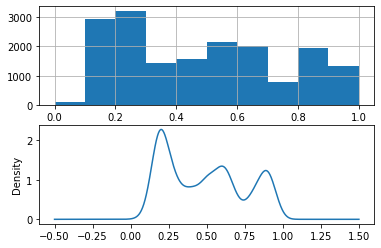

In [11]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
data.load.hist()
pyplot.subplot(212)
data.load.plot(kind='kde')
pyplot.show()

In [12]:
data.head(5)

,date,load
0,2009-01-01 01:00:00,0.226203
1,2009-01-01 02:00:00,0.203901
2,2009-01-01 03:00:00,0.184117
3,2009-01-01 04:00:00,0.183099
4,2009-01-01 05:00:00,0.177528


In [13]:
data["year"] = data["date"].apply(lambda x: x.year)
data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
data["hour"] = data["date"].apply(lambda x: x.hour)

In [14]:
data.set_index(pd.to_datetime(data['date']), inplace=True)

In [15]:
import holidays

de_holidays = holidays.Malaysia()
cet_dates = pd.Series(data.index, index=data.index)
data["holiday"] = cet_dates.apply(lambda d: d in de_holidays)
data["holiday"] = data["holiday"].astype(int)

In [16]:
#lags
counter = np.arange(1,25)
lags=[23, 24, 25, 47,48,49,71,72]
lag_cols = [f"conso_lag_{cn}" for cn in lags ]
for lag, lag_col in zip(lags, lag_cols):
    data[lag_col] = data["load"].shift(lag)

In [17]:
data.dropna(inplace=True)

In [18]:
features = ["hour", "day_of_week","holiday"]
hours = data["hour"]
dows = data["day_of_week"]
holidays = data["holiday"]
lags = data[lag_cols]
X = np.c_[np.asarray(hours), np.asarray(dows), np.asarray(holidays), np.asarray(lags)]
num_features = X.shape[1]
num_periods = len(data)
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(data["load"]).reshape((-1, num_periods))
quantiles = [0.1, 0.5, 0.9]

In [19]:
feature_size = X.shape[2]

In [20]:
class TransAm(nn.Module):
    def __init__(self,global_hidden_size, num_layers=1,feature_size=feature_size,dropout=0.2):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        # self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=feature_size, dropout=dropout)
        ### how many encoder layers you want
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        ### decoder 
        self.decoder = nn.Linear(feature_size, global_hidden_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

100% |########################################################################|
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.40it/s]


p50 [0.2008803  0.1849809  0.16918263 0.17222502 0.18418107 0.19283904
 0.20520744 0.30076617 0.48529108 0.66971993 0.78405562 0.78692496
 0.79833424 0.77653545 0.80925736 0.80236587 0.71298072 0.66135964
 0.62085062 0.6397191  0.56930208 0.48039889 0.39209808 0.20172357]
P50 MAPE: 0.19503378022651005


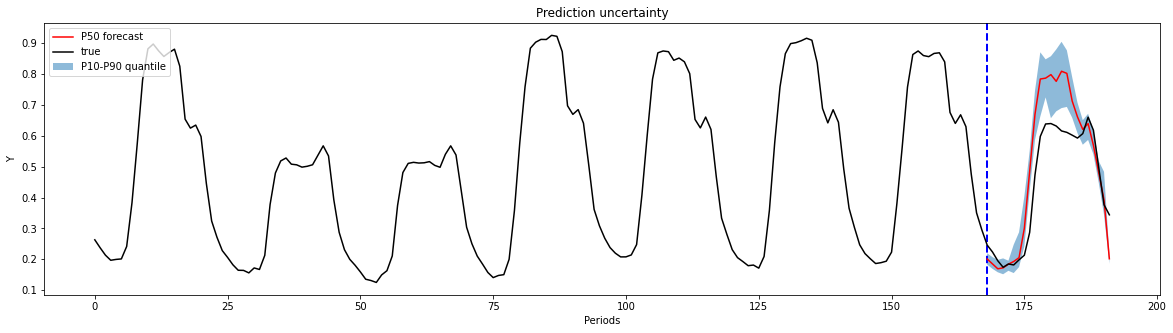

In [21]:
losses, mape_list, yscaler, model, Xte, yte  = train(X, y, args)

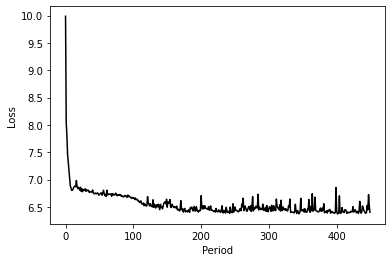

In [22]:
plt.plot(range(len(losses)), losses, "k-")
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()

In [23]:
num_ts, _, num_features = Xte.shape

In [24]:
# test

p50_list=[]
p90_list=[]
p10_list=[]
true_values=[]
pp = (Xte.shape[1]-seq_len) //num_obs_to_train
pp =30
for k in tqdm(range(pp)):
    
    mape_list = []
    #create the test sets
    X_test = Xte[:, num_obs_to_train*k:num_obs_to_train*(k+1), :].reshape((num_ts, -1, num_features))
    Xf_test = Xte[:, num_obs_to_train*(k+1):seq_len+num_obs_to_train*(k+1), :].reshape((num_ts, -1, num_features))
    y_test = yte[:, num_obs_to_train*k:num_obs_to_train*(k+1)].reshape((num_ts, -1))
    yf_test = yte[:, num_obs_to_train*(k+1):seq_len+num_obs_to_train*(k+1)].reshape((num_ts, -1))
    
    
    # select skus with most top K
    if yscaler is not None:
        y_test = yscaler.transform(y_test)
    
    result = []
    n_samples = args["sample_size"]
    for _ in range(n_samples):
        y_pred = model.sample(Xf_test)
        y_pred = y_pred.data.numpy()
        if yscaler is not None:
            y_pred = yscaler.inverse_transform(y_pred)
        result.append(y_pred.reshape((-1, 1)))
    
    result = np.concatenate(result, axis=1)
    p50 = np.quantile(result, 0.5, axis=1)
    p90 = np.quantile(result, 0.9, axis=1)
    p10 = np.quantile(result, 0.1, axis=1)
    
    
    p50_list.append(p50)
    p90_list.append(p90)
    p10_list.append(p10)
    true_values.append(yf_test[0])


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:00<00:00,  2.03s/it]


In [25]:
p90_list= np.array(p90_list).flatten()
p50_list= np.array(p50_list).flatten()
p10_list= np.array(p10_list).flatten()
true_values= np.array(true_values).flatten()

In [26]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f"MAE: {mean_absolute_error(true_values, p50_list)}, RMSE: {mean_squared_error(true_values, p50_list) ** 0.5}, MAPE: {mean_absolute_percentage_error(true_values, p50_list)}")
print( "The accuracy of the model is: %f" %r2_score(true_values, p50_list))

MAE: 0.07728740473099581, RMSE: 0.09767838818778148, MAPE: 0.14961148278791322
The accuracy of the model is: 0.870177


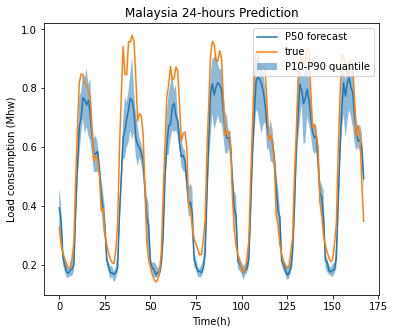

In [27]:
fig = plt.figure(1, figsize=(6,5))
plt.plot(p50_list[0:168])
plt.plot(true_values[0:168])
plt.fill_between(x=np.arange(168), y1=p10_list[0:168], y2=p90_list[0:168], alpha=0.5)
plt.title('Malaysia 24-hours Prediction')
plt.legend(["P50 forecast", "true", "P10-P90 quantile"], loc="upper right")
ymin, ymax = plt.ylim()
plt.xlabel('Time(h)')
plt.ylabel('Load consumption (Mhw)')
plt.show()